Texas power forecast project

In [44]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, ConciseDateFormatter
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

import statsmodels.api as sm



%matplotlib inline

# Exploring 

In [2]:
! ls ../Data/texasPowerGrid.csv

../Data/texasPowerGrid.csv


In [3]:
texas = pd.read_csv('../Data/texasPowerGrid.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
texas.set_index(pd.to_datetime(texas['UTC Time at End of Hour']), inplace=True)
texas

,Unnamed: 0,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,UTC Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),...,Region,Net Generation (MW) from Coal,Net Generation (MW) from Natural Gas,Net Generation (MW) from Nuclear,Net Generation (MW) from All Petroleum Products,Net Generation (MW) from Hydropower and Pumped Storage,Net Generation (MW) from Solar,Net Generation (MW) from Wind,Net Generation (MW) from Other Fuel Sources,Net Generation (MW) from Unknown Fuel Sources
UTC Time at End of Hour,,,,,,,,,,,,,,,,,,,,,
2018-01-01 07:00:00,65148,ERCO,01/01/2018,1,01/01/2018 1:00:00 AM,01/01/2018 7:00:00 AM,"47,834","50,587","50,800",212,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:00:00,65149,ERCO,01/01/2018,2,01/01/2018 2:00:00 AM,01/01/2018 8:00:00 AM,"48,313","50,650","51,036",385,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 09:00:00,65150,ERCO,01/01/2018,3,01/01/2018 3:00:00 AM,01/01/2018 9:00:00 AM,"49,513","50,737","50,887",150,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 10:00:00,65151,ERCO,01/01/2018,4,01/01/2018 4:00:00 AM,01/01/2018 10:00:00 AM,"48,663","51,021","51,419",398,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 11:00:00,65152,ERCO,01/01/2018,5,01/01/2018 5:00:00 AM,01/01/2018 11:00:00 AM,"50,639","51,727","52,048",321,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-06 02:00:00,56839,ERCO,12/05/2022,20,12/05/2022 8:00:00 PM,12/06/2022 2:00:00 AM,"45,525",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06 03:00:00,56840,ERCO,12/05/2022,21,12/05/2022 9:00:00 PM,12/06/2022 3:00:00 AM,"44,590",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-06 04:00:00,56841,ERCO,12/05/2022,22,12/05/2022 10:00:00 PM,12/06/2022 4:00:00 AM,"43,224",NaN,NaN,NaN,...,TEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
texas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43200 entries, 2018-01-01 07:00:00 to 2022-12-06 06:00:00
Data columns (total 25 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              43200 non-null  int64  
 1   Balancing Authority                                     43200 non-null  object 
 2   Data Date                                               43200 non-null  object 
 3   Hour Number                                             43200 non-null  int64  
 4   Local Time at End of Hour                               43200 non-null  object 
 5   UTC Time at End of Hour                                 43200 non-null  object 
 6   Demand Forecast (MW)                                    43104 non-null  object 
 7   Demand (MW)                                             43080 non-null  object 
 8   N

most of columns are object type, might be because of null values, will further look into each of columns

## Total Interchange (MW) 
this is our target to predict

In [5]:
texas['Total Interchange (MW)'] 

UTC Time at End of Hour
2018-01-01 07:00:00    212
2018-01-01 08:00:00    385
2018-01-01 09:00:00    150
2018-01-01 10:00:00    398
2018-01-01 11:00:00    321
                      ... 
2022-12-06 02:00:00    NaN
2022-12-06 03:00:00    NaN
2022-12-06 04:00:00    NaN
2022-12-06 05:00:00    NaN
2022-12-06 06:00:00    NaN
Name: Total Interchange (MW), Length: 43200, dtype: object

Will convert from object to float

In [5]:
texas['Total Interchange (MW)'] = texas['Total Interchange (MW)'].str.replace(',', '').astype(float)
texas['Total Interchange (MW)']

UTC Time at End of Hour
2018-01-01 07:00:00    212.0
2018-01-01 08:00:00    385.0
2018-01-01 09:00:00    150.0
2018-01-01 10:00:00    398.0
2018-01-01 11:00:00    321.0
                       ...  
2022-12-06 02:00:00      NaN
2022-12-06 03:00:00      NaN
2022-12-06 04:00:00      NaN
2022-12-06 05:00:00      NaN
2022-12-06 06:00:00      NaN
Name: Total Interchange (MW), Length: 43200, dtype: float64

check for null val

In [6]:
texas['Total Interchange (MW)'].isna().sum()

125

seem like the most recent days have a null value

In [7]:
texas.dropna(subset=['Total Interchange (MW)'], inplace=True)

In [8]:
texas['Total Interchange (MW)'].isna().sum()

0

Interchange is the target, will do exploration on this columns

## Interchange

<AxesSubplot:xlabel='UTC Time at End of Hour'>

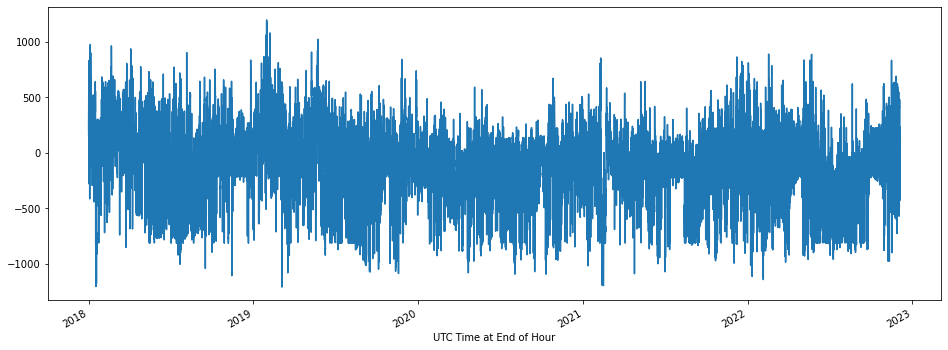

In [9]:
inter = texas['Total Interchange (MW)']
inter.plot(figsize=(16,6))

### Interchange check individual years

In [12]:
year_groups = inter.resample('MS').mean().groupby(pd.Grouper(freq='A'))
year_groups

In [67]:
year_groups.groups

{Timestamp('2018-12-31 00:00:00', freq='A-DEC'): 365,
 Timestamp('2019-12-31 00:00:00', freq='A-DEC'): 730,
 Timestamp('2020-12-31 00:00:00', freq='A-DEC'): 1096,
 Timestamp('2021-12-31 00:00:00', freq='A-DEC'): 1461,
 Timestamp('2022-12-31 00:00:00', freq='A-DEC'): 1800}

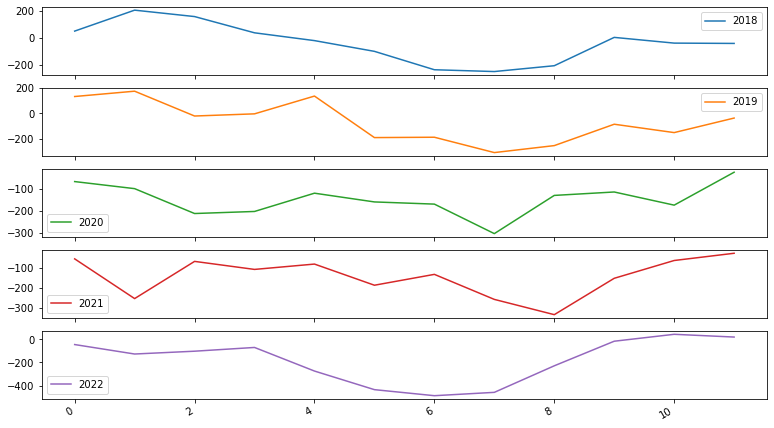

In [13]:
# Create a new DataFrame and store yearly values in columns 
inter2 = pd.DataFrame()

for yr, group in year_groups:
    inter2[yr.year] = group.values.ravel()


# Plot the yearly groups as subplots
inter2.plot(figsize = (13,8), subplots=True, legend=True);

In [ ]:
inter2.plot(figsize = (13,8), subplots=False, legend=True);

interchange gets higher negative values between june and august, supply not enough for demand most likely due to AC usage during summer season

In [ ]:
inter2.boxplot(figsize = (12,7));

interchange value mean gets lower into the negative numbers every year, doesnt seem to be many outliers to handle

Sometimes the distribution of the values is important.

What are some reasons?

Checking for normality (for stat testing)


First check on raw data

In [ ]:
inter.hist()

In [ ]:
inter.plot(kind='kde', figsize = (15,10));

bit skew to the left, more negatives

### split test data

In [10]:
cutoff = round(inter.shape[0]*0.8)
cutoff

train = inter[:cutoff]

test = inter[cutoff:]

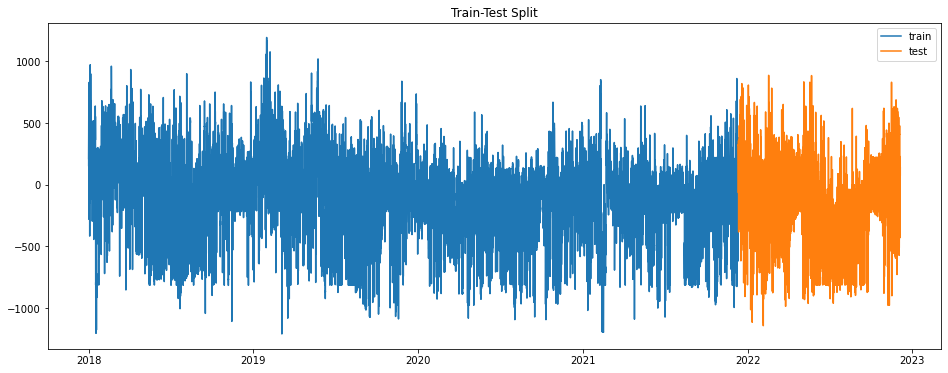

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [ ]:
# ### Import Packages ###
# import itertools
# import statsmodels.api as sm

# ### Define Parameter Ranges to Test ###
# # Note: higher numbers will result in code taking much longer to run
# # Here we have it set to test p,d,q each = 0, 1 & 2
# # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
# p = d = q = range(0, 3)
# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the ‘s’ position as we have monthly data
# # You’ll want to change this according to your time series’ frequency
# pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
# ### Run Grid Search ###
# # Note: this code will take a while to run
# # Define function
# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='H'):
#     '''
#     Input:
#         ts : your time series data
#         pdq : ARIMA combinations from above
#         pdqs : seasonal ARIMA combinations from above
#         maxiter : number of iterations, increase if your model isn’t converging
#         frequency : default=‘M’ for month. Change to suit your time series frequency
#             e.g. ‘D’ for day, ‘H’ for hour, ‘Y’ for year.
#     Return:
#         Prints out top 5 parameter combinations
#         Returns dataframe of parameter combinations ranked by BIC
#     '''
#     # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
#             try:
#                 mod = sm.SARIMAX(ts, # this is your time series you will input
#                                                 order=comb,
#                                                 seasonal_order=combs,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False,
#                                                 freq=freq)
#                 output = mod.fit(maxiter=maxiter)
#                 ans.append([comb, combs, output.bic])
#                 print('SARIMAX {} x {}12 :  bic Calculated ={}'.format(comb, combs, output.bic))
#             except:
#                 continue
#     # Find the parameters with minimal BIC value
#     # Convert into dataframe
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
#     # Sort and return top 5 combinations
#     ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
#     return ans_df
# ### Apply function to your time series data ###
# # Remember to change frequency to match your time series data
# # sarimax_gridsearch(train, pdq, pdqs, freq='H')

## Grid search

In [13]:
import statsmodels.api as sm
import itertools

In [14]:
import statsmodels.api as sm
import itertools
# Grid Search
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 24 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
bics = []
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(train, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model = model.fit()
            combs.update({model.bic : [combination, seasonal_combination]})
            bics.append(model.bic)
            
        except:
            continue
            
best_bic = min(bics)
# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(train, order=combs[best_bic][0], seasonal_order=combs[best_bic][1],
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model = model.fit()
model.forecast(7)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: Val

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

34460    1.295160e+07
34461    1.295301e+07
34462    1.295444e+07
34463    1.295590e+07
34464    1.295733e+07
34465    1.295876e+07
34466    1.296023e+07
Name: predicted_mean, dtype: float64

In [15]:
best_bic

224478.39108868482

In [20]:
len(bics)

216

In [18]:
combs

{496336.32172734506: [(0, 0, 0), (0, 0, 0, 24)],
 486599.7865858887: [(0, 0, 0), (0, 0, 1, 24)],
 489195.94147108117: [(0, 0, 0), (0, 1, 0, 24)],
 479196.81360228645: [(0, 0, 0), (0, 1, 1, 24)],
 481303.3814671283: [(0, 0, 0), (1, 0, 0, 24)],
 478586.9016861344: [(0, 0, 0), (1, 0, 1, 24)],
 483963.27097789233: [(0, 0, 0), (1, 1, 0, 24)],
 477243.45869847486: [(0, 0, 0), (1, 1, 1, 24)],
 465787.48743042076: [(0, 0, 1), (0, 0, 0, 24)],
 459117.5032887481: [(0, 0, 1), (0, 0, 1, 24)],
 465558.81190454686: [(0, 0, 1), (0, 1, 0, 24)],
 453220.9445531003: [(0, 0, 1), (0, 1, 1, 24)],
 455875.1010930189: [(0, 0, 1), (1, 0, 0, 24)],
 452858.37292400864: [(0, 0, 1), (1, 0, 1, 24)],
 459348.35837247013: [(0, 0, 1), (1, 1, 0, 24)],
 451802.0332502275: [(0, 0, 1), (1, 1, 1, 24)],
 457153.13538177096: [(0, 0, 2), (0, 0, 0, 24)],
 447063.4874030623: [(0, 0, 2), (0, 0, 1, 24)],
 456718.52306830365: [(0, 0, 2), (0, 1, 0, 24)],
 442359.13985693787: [(0, 0, 2), (0, 1, 1, 24)],
 445205.0050699825: [(0, 0, 

In [ ]:
# 224478.39108868482: [(1, 2, 2), (0, 1, 1, 24)],

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:               Total Interchange (MW)   No. Observations:                34460
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 24)   Log Likelihood             -112213.081
Date:                              Wed, 07 Dec 2022   AIC                         224436.161
Time:                                      07:32:04   BIC                         224478.391
Sample:                                           0   HQIC                        224449.623
                                            - 34460                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8772      0.006    152.298      0.000       0.866       0.889
ma.L1         -1.9982   1.16e-07  -1.73e+07      0.000      -1.998      -1.998
ma.L2          0.9982   4.21e-08   2.37e+07      0.000       0.998       0.998
ma.S.L24      -0.9286   2.64e-05  -3.51e+04      0.000      -0.929      -0.929
sigma2      3.214e+04   1.66e-08   1.94e+12      0.000    3.21e+04    3.21e+04
===================================================================================
Ljung-Box (L1) (Q):                  69.07   Jarque-Bera (JB):            109090.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+26. Standard errors may be unstable.
"""

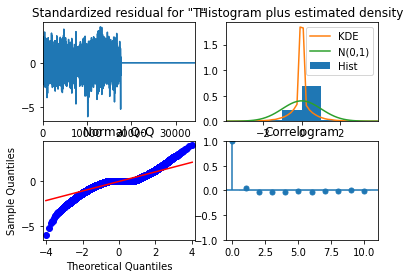

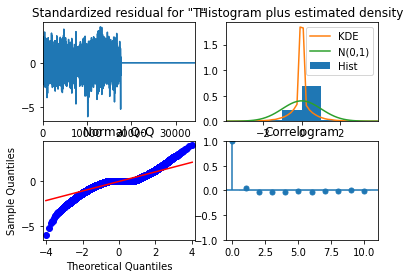

In [78]:
model.plot_diagnostics()

In [ ]:
# 224478.39108868482: [(1, 2, 2), (0, 1, 1, 24)],

Trying to run it again with bet parameters

In [12]:
trainD = train.resample('MS').mean()
testD = test.resample('MS').mean()


model2 = sm.tsa.statespace.SARIMAX(trainD, order=(1, 2, 2), seasonal_order=(0, 1, 1, 12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model2 = model2.fit()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [120]:
y_hat_train = model2.predict(typ='levels')

In [121]:
y_hat_test = model2.predict(start='2021-12-11', end='2022-12-05', typ='levels')

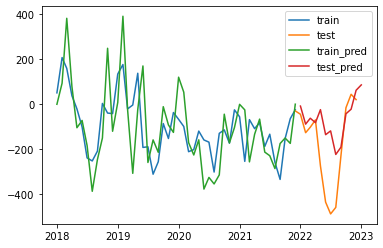

In [122]:
fig, ax = plt.subplots()
ax.plot(trainD, label='train')
ax.plot(testD, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

#  weather dataset

In [28]:
! ls ../Data

960x0.jpg                  Dallas_Weather.csv
Amarillo_Weather.csv       El_Paso_Weather.csv
Corpus_Christi_Weather.csv texasPowerGrid.csv


In [12]:
el_paso_weather = pd.read_csv('../Data/El_Paso_Weather.csv')

In [13]:
corpus_christi_weather = pd.read_csv('../Data/Corpus_Christi_Weather.csv')

In [14]:
dallas_weather = pd.read_csv('../Data/Dallas_Weather.csv')

In [15]:
amarillo_weather = pd.read_csv('../Data/Amarillo_Weather.csv')

In [16]:
weather_station_list = [el_paso_weather, corpus_christi_weather, dallas_weather, amarillo_weather]

for station in weather_station_list:
    station.set_index(pd.to_datetime(station['DATE']), inplace=True) 

In [17]:
weather = pd.DataFrame()

weather['el_paso_AWND'] = el_paso_weather['AWND']
weather['corpus_christi_AWND'] = corpus_christi_weather['AWND']
weather['dallas_AWND'] = dallas_weather['AWND']
weather['amarillo_AWND'] = amarillo_weather['AWND']

weather['el_paso_PRCP'] = el_paso_weather['PRCP']
weather['corpus_christi_PRCP'] = corpus_christi_weather['PRCP']
weather['dallas_PRCP'] = dallas_weather['PRCP']
weather['amarillo_PRCP'] = amarillo_weather['PRCP']

weather['el_paso_SNOW'] = el_paso_weather['SNOW']
weather['corpus_christi_SNOW'] = corpus_christi_weather['SNOW']
weather['dallas_SNOW'] = dallas_weather['SNOW']
weather['amarillo_SNOW'] = amarillo_weather['SNOW']

weather['el_paso_TMAX'] = el_paso_weather['TMAX']
weather['corpus_christi_TMAX'] = corpus_christi_weather['TMAX']
weather['dallas_TMAX'] = dallas_weather['TMAX']
weather['amarillo_TMAX'] = amarillo_weather['TMAX']

weather['el_paso_TMIN'] = el_paso_weather['TMIN']
weather['corpus_christi_TMIN'] = corpus_christi_weather['TMIN']
weather['dallas_TMIN'] = dallas_weather['TMIN']
weather['amarillo_TMIN'] = amarillo_weather['TMIN']

In [18]:
weather['corpus_christi_AWND'].bfill(inplace=True)

In [19]:
weather

,el_paso_AWND,corpus_christi_AWND,dallas_AWND,amarillo_AWND,el_paso_PRCP,corpus_christi_PRCP,dallas_PRCP,amarillo_PRCP,el_paso_SNOW,corpus_christi_SNOW,dallas_SNOW,amarillo_SNOW,el_paso_TMAX,corpus_christi_TMAX,dallas_TMAX,amarillo_TMAX,el_paso_TMIN,corpus_christi_TMIN,dallas_TMIN,amarillo_TMIN
DATE,,,,,,,,,,,,,,,,,,,,
2018-01-01,5.14,16.78,11.41,9.17,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,46,37,30,21,27.0,32,17,4
2018-01-02,5.14,15.43,8.05,9.62,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,57,39,28,30,30.0,31,21,2
2018-01-03,3.80,10.74,7.61,8.95,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,56,52,50,53,24.0,27,19,14
2018-01-04,5.59,5.14,3.36,9.17,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,53,59,51,52,37.0,29,27,23
2018-01-05,4.25,8.28,6.26,7.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,64,62,64,57,32.0,41,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27,10.51,6.71,9.62,10.51,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,66,76,64,47,45.0,49,45,32
2022-11-28,13.20,7.38,9.84,16.55,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,67,72,69,65,42.0,56,38,30
2022-11-29,11.41,10.29,16.11,18.79,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,71,86,81,58,47.0,64,43,20


In [20]:
daily_int = pd.DataFrame(inter.resample('D').mean())

In [21]:
daily_int

,Total Interchange (MW)
UTC Time at End of Hour,
2018-01-01,285.352941
2018-01-02,452.625000
2018-01-03,4.333333
2018-01-04,275.041667
2018-01-05,519.625000
...,...
2022-12-01,78.375000
2022-12-02,17.916667
2022-12-03,11.041667


In [22]:
joined = pd.merge(daily_int, weather, left_index=True, right_index=True)
joined.isna().sum()

Total Interchange (MW)    2
el_paso_AWND              0
corpus_christi_AWND       0
dallas_AWND               0
amarillo_AWND             0
el_paso_PRCP              0
corpus_christi_PRCP       0
dallas_PRCP               0
amarillo_PRCP             0
el_paso_SNOW              0
corpus_christi_SNOW       0
dallas_SNOW               0
amarillo_SNOW             0
el_paso_TMAX              0
corpus_christi_TMAX       0
dallas_TMAX               0
amarillo_TMAX             0
el_paso_TMIN              1
corpus_christi_TMIN       0
dallas_TMIN               0
amarillo_TMIN             0
dtype: int64

In [23]:
joined.bfill(inplace=True)

In [25]:
joined.isna().sum()

Total Interchange (MW)    0
el_paso_AWND              0
corpus_christi_AWND       0
dallas_AWND               0
amarillo_AWND             0
el_paso_PRCP              0
corpus_christi_PRCP       0
dallas_PRCP               0
amarillo_PRCP             0
el_paso_SNOW              0
corpus_christi_SNOW       0
dallas_SNOW               0
amarillo_SNOW             0
el_paso_TMAX              0
corpus_christi_TMAX       0
dallas_TMAX               0
amarillo_TMAX             0
el_paso_TMIN              0
corpus_christi_TMIN       0
dallas_TMIN               0
amarillo_TMIN             0
dtype: int64

In [26]:
joined_w = joined.resample('W').mean()
joined_w

,Total Interchange (MW),el_paso_AWND,corpus_christi_AWND,dallas_AWND,amarillo_AWND,el_paso_PRCP,corpus_christi_PRCP,dallas_PRCP,amarillo_PRCP,el_paso_SNOW,...,dallas_SNOW,amarillo_SNOW,el_paso_TMAX,corpus_christi_TMAX,dallas_TMAX,amarillo_TMAX,el_paso_TMIN,corpus_christi_TMIN,dallas_TMIN,amarillo_TMIN
2018-01-07,264.490896,5.750000,11.281429,8.755714,10.194286,0.000000,0.000000,0.025714,0.000000,0.0,...,0.0,0.0,58.714286,55.857143,50.142857,46.714286,33.142857,37.142857,28.857143,17.142857
2018-01-14,147.452381,8.150000,11.855714,12.335714,13.452857,0.014286,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,64.142857,69.428571,55.285714,59.857143,37.571429,42.285714,33.571429,25.428571
2018-01-21,-221.410714,7.892857,12.495714,13.741429,14.282857,0.000000,0.048571,0.084286,0.000000,0.0,...,0.0,0.0,55.428571,60.000000,54.857143,52.857143,29.000000,41.000000,32.714286,19.142857
2018-01-28,-26.595238,7.572857,8.948571,10.131429,13.038571,0.000000,0.132857,0.011429,0.000000,0.0,...,0.0,0.0,60.142857,68.714286,65.142857,57.571429,32.000000,47.428571,40.000000,23.428571
2018-02-04,132.250000,6.612857,10.514286,13.551429,13.070000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,70.000000,72.142857,63.857143,60.285714,37.714286,49.428571,38.571429,24.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-06,-24.327381,7.958571,11.984286,9.427143,14.572857,0.000000,0.468571,0.430000,0.022857,0.0,...,0.0,0.0,73.571429,78.857143,76.571429,70.000000,45.285714,65.428571,53.714286,42.142857
2022-11-13,-127.363095,6.295714,12.175714,9.235714,16.201429,0.000000,0.002857,0.078571,0.000000,0.0,...,0.0,0.0,71.714286,79.142857,70.714286,61.285714,43.714286,60.285714,52.714286,37.571429
2022-11-20,92.696429,7.542857,15.434286,7.667143,10.161429,0.000000,0.098571,0.064286,0.000000,0.0,...,0.0,0.0,55.571429,58.142857,50.000000,44.571429,36.428571,47.000000,36.000000,21.285714
2022-11-27,119.130952,9.140000,11.184286,8.275714,11.535714,0.017143,0.164286,0.341429,0.024286,0.0,...,0.0,0.0,61.142857,64.857143,58.285714,51.714286,35.714286,52.142857,46.428571,29.285714


### Split Data and perform gridsearch with exog vairables

used weekly data, and S = 52

In [27]:
cutoff = round(joined_w.shape[0]*0.8)
cutoff

train_D_W = joined_w[:cutoff]

test_D_W = joined_w[cutoff:]

In [28]:
# Grid Search
p = d = q = range(0, 3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 52 # the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
rmse_list = []

# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(endog=train_D_W['Total Interchange (MW)'], 
                                              exog=train_D_W[['el_paso_AWND', 'corpus_christi_AWND', 
                                                              'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP', 
                                                              'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW', 
                                                              'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX', 
                                                              'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN', 
                                                              'dallas_TMIN', 'amarillo_TMIN']], 
                                              order=combination, 
                                              seasonal_order=seasonal_combination, 
                                              enforce_stationarity=True, 
                                              enforce_invertibility=False)
            
            model = model.fit()
            model_preds = model.predict(start=test_D_W.index[0], 
                                        end=test_D_W.index[-1], 
                                        exog=test_D_W[['el_paso_AWND', 'corpus_christi_AWND', 'dallas_AWND', 
                                                       'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP', 
                                                       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 
                                                       'corpus_christi_SNOW', 'dallas_SNOW', 'amarillo_SNOW', 
                                                       'el_paso_TMAX', 'corpus_christi_TMAX', 'dallas_TMAX', 
                                                       'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN', 
                                                       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')
            
            rmse_result = rmse(model_preds, test_D_W['Total Interchange (MW)'])
            combs.update({rmse_result : [combination, seasonal_combination]})
            rmse_list.append(rmse_result)
            
        except:
            continue
        
        print(len(rmse_list))
            
            
best_rmse = min(rmse_list)
# Modeling and forcasting
best_model = sm.tsa.statespace.SARIMAX(endog=train_D_W['Total Interchange (MW)'], exog=train_D_W[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=combs[best_rmse][0], seasonal_order=combs[best_rmse][1],
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
best_model = best_model.fit()


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python

ValueError: min() arg is an empty sequence

last grid search gave an error, will run mudels based on team mates best parametters , order = 1 1 1, seasonal order = 1, 1, 1 and 52 trying to find good results using a year as season

below is code part of the grid search, will explore to debug running small number of iterations
for the predict line, changed the start and end arg for strings instead of the test set index

In [ ]:
# 111, 111 52 

In [43]:

model = sm.tsa.statespace.SARIMAX(endog=train_D_W['Total Interchange (MW)'], 
                                              exog=train_D_W[feat_columns], 
                                              order=(1, 1, 1), 
                                              seasonal_order=(1, 1, 1, 52), 
                                              enforce_stationarity=True, 
                                              enforce_invertibility=False)
            
model = model.fit()
model_preds1 = model.predict(start='2021-12-19', 
                                        end='2022-12-04', 
                                        exog=test_D_W[feat_columns], typ='levels')
            
# rmse_result1 = rmse(model_preds, test_D_W['Total Interchange (MW)'])
# combs.update({rmse_result : [combination, seasonal_combination]})
# rmse_list.append(rmse_result)


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NameError: name 'rmse' is not defined

In [ ]:
rmse_result1 = rmse(model_preds1, test_D_W['Total Interchange (MW)'])
rmse_result1

will run model using best parameters from a gridsearch, it was run suing daily data points and a weekly seasonality (7), 
i keep all orders the same, using weekly data points and season of 52

In [45]:
model0 = SARIMAX(train_D_W['Total Interchange (MW)'], exog=train_D_W[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], seasonal_order=(1, 1, 1, 52), order=(1, 1, 1))
res_model0 = model0.fit()
print(res_model0.summary())

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:             Total Interchange (MW)   No. Observations:                  206
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -953.586
Date:                            Thu, 08 Dec 2022   AIC                           1957.172
Time:                                    08:11:30   BIC                           2032.933
Sample:                                01-07-2018   HQIC                          1987.947
                                     - 12-12-2021                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
el_paso_AWND           -0.9508      8.728     -0.109      0.913     -18.058      16.156
corpus_c

In [50]:
model_preds3 = res_model0.predict(start=test_D_W.index[0], end=test_D_W.index[-1], exog=test_D_W[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')

In [53]:
rmse_result = rmse(model_preds3, test_D_W['Total Interchange (MW)'])
rmse_result

206.26990126715543

In [ ]:
y_hat_train3 = res_model0.predict(typ='levels')

In [ ]:
y_hat_test3 = model_preds3

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
# ax.plot(train_D_W['Total Interchange (MW)']['2021':'2022'], label='train')
ax.plot(test_D_W['Total Interchange (MW)']['2022':], label='True')
# ax.plot(y_hat_train3['2021':'2022'], label='train_pred')
ax.plot(y_hat_test3['2022':], label='Prediction')
ax.hlines(y=0, xmin=min(y_hat_test3.index), xmax=max(y_hat_test3.index), colors='black')
plt.legend();
# plt.savefig("untitledfolder", dpi=600, bbox_inches="tight", transparent=False);

rmse slightly better than 218 from model before.

next, lets see a model using same orders but a s=365 using daly data points

In [54]:
joined

,Total Interchange (MW),el_paso_AWND,corpus_christi_AWND,dallas_AWND,amarillo_AWND,el_paso_PRCP,corpus_christi_PRCP,dallas_PRCP,amarillo_PRCP,el_paso_SNOW,...,dallas_SNOW,amarillo_SNOW,el_paso_TMAX,corpus_christi_TMAX,dallas_TMAX,amarillo_TMAX,el_paso_TMIN,corpus_christi_TMIN,dallas_TMIN,amarillo_TMIN
2018-01-01,285.352941,5.14,16.78,11.41,9.17,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,46,37,30,21,27.0,32,17,4
2018-01-02,452.625000,5.14,15.43,8.05,9.62,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,57,39,28,30,30.0,31,21,2
2018-01-03,4.333333,3.80,10.74,7.61,8.95,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,56,52,50,53,24.0,27,19,14
2018-01-04,275.041667,5.59,5.14,3.36,9.17,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,53,59,51,52,37.0,29,27,23
2018-01-05,519.625000,4.25,8.28,6.26,7.61,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,64,62,64,57,32.0,41,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27,237.250000,10.51,6.71,9.62,10.51,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,66,76,64,47,45.0,49,45,32
2022-11-28,109.750000,13.20,7.38,9.84,16.55,0.0,0.01,0.0,0.0,0.0,...,0.0,0.0,67,72,69,65,42.0,56,38,30
2022-11-29,422.416667,11.41,10.29,16.11,18.79,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,71,86,81,58,47.0,64,43,20
2022-11-30,299.208333,4.92,16.78,10.51,12.08,0.0,0.01,0.0,0.0,0.0,...,0.0,0.0,66,67,51,40,39.0,52,35,14


In [59]:
cutoff = round(joined.shape[0]*0.8)
cutoff

train_D = joined[:cutoff]

test_D = joined[cutoff:]

In [ ]:
model5 = SARIMAX(train_D['Total Interchange (MW)'], exog=train_D[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], seasonal_order=(1, 1, 1, 365), order=(1, 1, 1))
res_model5 = model5.fit()
print(res_model5.summary())

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
model_preds5 = res_model5.predict(start=test_D.index[0], end=test_D.index[-1], exog=test_D[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')


In [ ]:
rmse_result = rmse(model_preds5, test_D_W['Total Interchange (MW)'])
rmse_result

In [ ]:
# from statsmodels.tools.eval_measures import rmse
# error=rmse(predictions[‘Pred’], predictions[‘Actual’])
# error

In [ ]:
# df6.columns

# model0 = SARIMAX(train_d_x['Total Interchange (MW)'], exog=train_d_x[['el_paso_AWND', 'corpus_christi_AWND',
#        'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
#        'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
#        'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
#        'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
#        'dallas_TMIN', 'amarillo_TMIN']], seasonal_order=(1,0,0,7))
# res_model0 = model0.fit()
# print(res_model0.summary())

# res_model0.predict(start=train_d_x.index[0], end=train_d_x.index[-1], typ='levels')

# model0_test_preds = res_model0.predict(start=test_d_x.index[0], end=test_d_x.index[-1], exog=test_d_x[['el_paso_AWND', 'corpus_christi_AWND',
#        'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
#        'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
#        'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
#        'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
#        'dallas_TMIN', 'amarillo_TMIN']], typ='levels')

# model0_test_preds

# error=rmse(model0_test_preds, test_d_x['Total Interchange (MW)'])
# error

In [ ]:
# split = TimeSeriesSplit()

In [ ]:
# train.isna().sum()

In [ ]:
# naive = train.shift(1)
# naive

In [ ]:
# fig, ax = plt.subplots()

# train[0:30].plot(ax=ax, c='r', label='original')
# naive[0:30].plot(ax=ax, c='b', label='shifted')
# ax.set_title('naive')
# ax.legend();

In [ ]:
# np.sqrt(mean_squared_error(train[1:], naive.dropna()))

In [ ]:
# fig, ax = plt.subplots(figsize = (16,6))
# residuals = naive[1:] - train[1:]
# ax.plot(residuals.index, residuals)
# ax.plot(residuals.index, residuals.rolling(30).std());

In [ ]:
# fig, ax = plt.subplots(figsize = (16,6))

# ax.plot(residuals.index, residuals.rolling(6).var());